# Preprocessing 
#### This file includes preprocessing steps and their plots for sleep stage classification.

Labels come from 2 different PSG systems: Remlogic and Somnomedics. EMFIT is the piezoelectric mat and Somnofy is the radar. Sleep stage labels are as follows:

0 = Awake  \
1 = REM  \
2 = Light  \
3 = Deep 

## Imports and Loading

In [1]:
import pandas as pd
import numpy as np
from loader import *
import matplotlib.pyplot as plt
from helpers import *

In [2]:
subjectID = PARTICIPANT_IDS[5]
len(PARTICIPANT_IDS)

50

In [3]:
# get_sleepstages retrieves the raw data given by the lab, 
# this function will not work for those who do not possess the original data.
# However, the processed data is already imputed and therefore it is hard to show the preprocessing steps on it.
sleep_stages = get_sleepstages(subjectID)

In [4]:
sleep_stages.head()

,sleep_stage_num_somnofy,sleep_stage_num_emfit,sleep_stage_num_psg
timestamp_local,,,
2021-09-15 21:48:30+00:00,2.0,2.0,2.0
2021-09-15 21:49:00+00:00,2.0,2.0,2.0
2021-09-15 21:49:30+00:00,2.0,2.0,2.0
2021-09-15 21:50:00+00:00,2.0,2.0,2.0
2021-09-15 21:50:30+00:00,2.0,2.0,2.0


<AxesSubplot:xlabel='timestamp_local'>

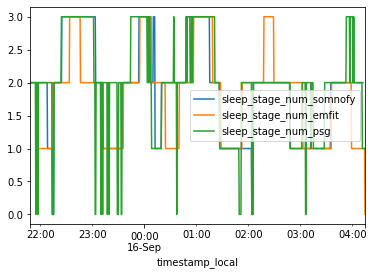

In [5]:
sleep_stages.plot()

#### Difference in patient PSG values by diagnosis

In [6]:
subjectID = PARTICIPANT_IDS[-1]
weird = read_patient_data(subjectID)
weird.reset_index(inplace=True)
normal = sleep_stages.reset_index(inplace=False)

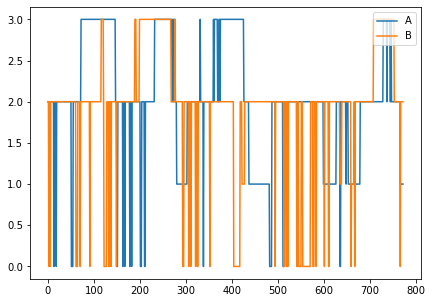

In [7]:
df = pd.merge(normal["sleep_stage_num_psg"], weird["sleep_stage_num_psg"], left_index=True, right_index=True)
df.plot(figsize=(7,5))
plt.legend(['A', 'B'], loc='upper right', prop={'size': 10})

In [8]:
sleep_stages.isna().sum()

sleep_stage_num_somnofy    31
sleep_stage_num_emfit       0
sleep_stage_num_psg         0
dtype: int64

Somnofy is missing where psg has the following values:
[[ 1.  2.  3.]
 [21.  8.  2.]]


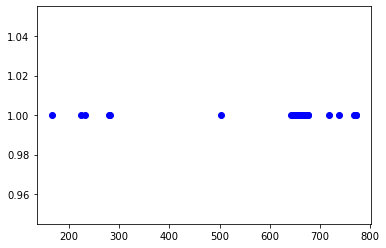

In [9]:
"""
1 -> missing values of radar
2 -> missing values of mat
3 -> missing values of psg
"""
plot_missing_sleepstages(sleep_stages)

## Imputing missing values
Comparison of three main techniques for time series data:
1. coping the previous or future value
2. having a rolling average and rounding it
3. Interpolation with "linear", "spline", "time", "quadratic"

In [10]:
df = pd.DataFrame()
df["somnofy"] = sleep_stages["sleep_stage_num_somnofy"]
df["truth"] = sleep_stages["sleep_stage_num_psg"]
df["Forward Fill"] = df["somnofy"].ffill()
df["Backward Fill"] = df["somnofy"].bfill()

<AxesSubplot:xlabel='timestamp_local'>

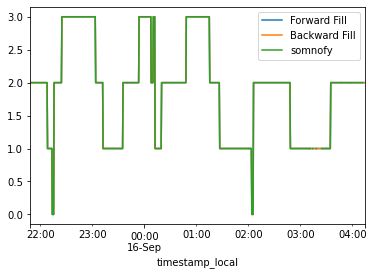

In [11]:
df[["Forward Fill", "Backward Fill", "somnofy"]].plot()

<AxesSubplot:xlabel='timestamp_local'>

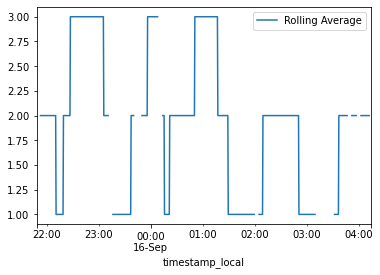

In [12]:
df["Rolling Average"] = df["somnofy"].rolling(window=10).mean().round()
df[["Rolling Average"]].plot()

<AxesSubplot:xlabel='timestamp_local'>

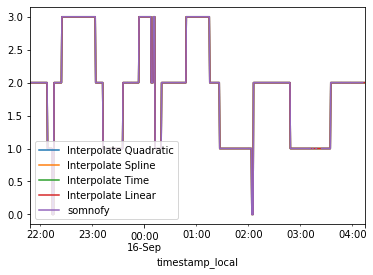

In [13]:
df["Interpolate Spline"]= df["somnofy"].interpolate(option='spline').round()
df["Interpolate Linear"]= df["somnofy"].interpolate(option='linear').round()
df["Interpolate Time"]= df["somnofy"].interpolate(option='time').round()
df["Interpolate Quadratic"]= df["somnofy"].interpolate(option='quadratic').round()
df[["Interpolate Quadratic", "Interpolate Spline", "Interpolate Time", "Interpolate Linear", "somnofy"]].plot()

In [14]:
# no difference between interpolation methods
diff = np.ones(3)
diff[0] = np.linalg.norm(df["somnofy"].interpolate(option='spline')-df["somnofy"].interpolate(option='linear'))
diff[1] = np.linalg.norm(df["somnofy"].interpolate(option='spline')-df["somnofy"].interpolate(option='time'))
diff[2] = np.linalg.norm(df["somnofy"].interpolate(option='spline')-df["somnofy"].interpolate(option='quadratic'))
diff

array([0., 0., 0.])

array([15.84297952, 15.84297952,         nan])

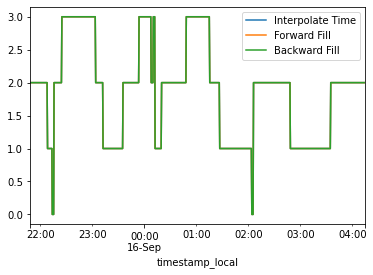

In [15]:
# decide which is best based on ground truth
df[["Interpolate Time", "Forward Fill", "Backward Fill"]].plot()
diff = np.ones(3)
diff[0] = np.linalg.norm(df["Interpolate Time"]-df["truth"].interpolate(option='time').round())
diff[1] = np.linalg.norm(df["Forward Fill"]-df["truth"].ffill())
diff[2] = np.linalg.norm(df["Backward Fill"]-df["truth"].ffill())
diff

In [16]:
# test_imputing()

In [17]:
# impute_all()

### Generate CNN Input

In [18]:
patients = []
lens = []
for subjectId in PARTICIPANT_IDS:
    sleep_stages = read_patient_data(subjectId)
    patients.append(sleep_stages)
    lens.append(sleep_stages.shape[0])
print(lens)

[931, 818, 1180, 843, 748, 773, 667, 888, 754, 910, 772, 670, 1319, 695, 1115, 1064, 1031, 635, 783, 561, 864, 839, 789, 793, 704, 632, 679, 888, 1144, 656, 1095, 703, 1491, 592, 752, 1173, 782, 694, 1064, 719, 647, 1269, 774, 1308, 1051, 656, 719, 668, 651, 1039]


In [19]:
print("MIN: ", min(lens))
print("MAX: ", max(lens))
print("MEAN: ", np.mean(lens))
print("STD: ", np.std(lens))

MIN:  561
MAX:  1491
MEAN:  859.84
STD:  217.85447987131226


In [20]:
mean = int(np.mean(lens))
less_data = [a for a in patients if len(a) < mean]
lens_less = [len(a) for a in less_data]
more_data = [a for a in patients if len(a) >= mean]
lens_more = [len(a) for a in more_data]

In [21]:
print("Less data: ", min(lens_less), max(lens_less), np.mean(lens_less), np.std(lens_less), len(lens_less))
print("More data: ", min(lens_more), max(lens_more), np.mean(lens_more), np.std(lens_more), len(lens_more))

Less data:  561 843 715.0967741935484 70.45994279007945 31
More data:  864 1491 1096.0 163.835283135227 19


In [22]:
# to retrieve divided data
x, y, x_big, y_big = get_nn_patients(divided=True)
x.shape, y.shape, x_big.shape, y_big.shape

((31, 713, 2), (31, 713), (19, 1087, 2), (19, 1087))

In [23]:
# to retrieve whole data
x, y, x_big, y_big = get_nn_patients()
x.shape, y.shape, x_big.shape, y_big.shape

((50, 857, 2), (50, 857), (0,), (0,))